In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle

In [2]:
!kaggle datasets download -d jainilcoder/netflix-stock-price-prediction

  0% 0.00/20.9k [00:00<?, ?B/s]
100% 20.9k/20.9k [00:00<00:00, 36.2MB/s]


In [3]:
import zipfile
zip= zipfile.ZipFile("/content/netflix-stock-price-prediction.zip","r")
zip.extractall("/content")
zip.close()

# **Reading the dataset**

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [5]:
df=pd.read_csv('/content/NFLX.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-02-05,262.000000,267.899994,250.029999,254.259995,254.259995,11896100
1,2018-02-06,247.699997,266.700012,245.000000,265.720001,265.720001,12595800
2,2018-02-07,266.579987,272.450012,264.329987,264.559998,264.559998,8981500
3,2018-02-08,267.079987,267.619995,250.000000,250.100006,250.100006,9306700
4,2018-02-09,253.850006,255.800003,236.110001,249.470001,249.470001,16906900


In [6]:
df.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [7]:
df.shape

(1009, 7)

# **Preprocess**

In [8]:
df=df["Close"]

In [9]:
df

0       254.259995
1       265.720001
2       264.559998
3       250.100006
4       249.470001
           ...    
1004    427.140015
1005    457.130005
1006    429.480011
1007    405.600006
1008    410.170013
Name: Close, Length: 1009, dtype: float64

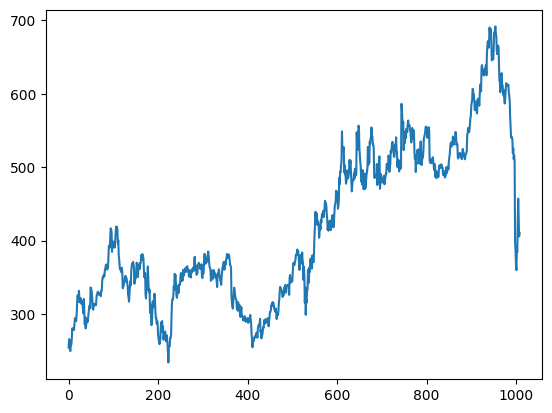

In [10]:
plt.plot(df)

In [11]:
from sklearn.preprocessing import MinMaxScaler

In [12]:
scaler=MinMaxScaler(feature_range=(0,1))
data=scaler.fit_transform(np.array(df).reshape(-1,1))

In [13]:
data

array([[0.04451626],
       [0.06954849],
       [0.06701469],
       ...,
       [0.4272515 ],
       [0.37509011],
       [0.38507243]])

# **Custom data split**

In [14]:
train_size = int(len(data)*0.65) #65% of data should be training
test_size = len(data)-train_size

In [15]:
train_size,test_size , len(data)

(655, 354, 1009)

In [16]:
train , test = data[0:train_size,:], data[train_size:len(data),:1]

In [17]:
len(train),len(test)

(655, 354)

In [18]:
def custom_dataset(dataset,time_step): #on how many prev values the o/p is dependent on
  X,Y = [],[]
  for i in range(len(dataset)-time_step-1):
    a = dataset[i:(i+time_step),0]  # if timestep = 3  i=0,1,2,3th(x)    4th(y)
    X.append(a)
    Y.append(dataset[i+time_step,0])
  return np.array(X),np.array(Y)

In [19]:
time_step = 50
X_train , y_train = custom_dataset(train,time_step)
X_test , y_test = custom_dataset(test,time_step)

In [20]:
X_train

array([[0.04451626, 0.06954849, 0.06701469, ..., 0.16987394, 0.16142066,
        0.22319301],
       [0.06954849, 0.06701469, 0.03542955, ..., 0.16142066, 0.22319301,
        0.21982915],
       [0.06701469, 0.03542955, 0.03405342, ..., 0.22319301, 0.21982915,
        0.21585376],
       ...,
       [0.50682598, 0.45765709, 0.46604484, ..., 0.70481201, 0.69670829,
        0.63753522],
       [0.45765709, 0.46604484, 0.48308251, ..., 0.69670829, 0.63753522,
        0.61634736],
       [0.46604484, 0.48308251, 0.54992248, ..., 0.63753522, 0.61634736,
        0.59662302]])

In [21]:
X_train.shape,y_train.shape

((604, 50), (604,))

Convert the data into 3 dimentions = (samples,time_step,features)

In [22]:
X_train = np.reshape(X_train,(X_train.shape[0],X_train.shape[1],1)) #(604,50,1)
X_test = np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))

In [23]:
X_train.shape

(604, 50, 1)

# **Model Creation**

In [24]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense,LSTM

In [49]:
model = Sequential()
model.add(LSTM(128,return_sequences=True,input_shape=(X_train.shape[1],1))) #(50,1)
model.add(LSTM(64,return_sequences=True))
model.add(LSTM(32))
model.add(Dense(16))
model.add(Dense(1))

model.compile(loss="mean_squared_error",optimizer='adam')

In [50]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 50, 128)           66560     
                                                                 
 lstm_4 (LSTM)               (None, 50, 64)            49408     
                                                                 
 lstm_5 (LSTM)               (None, 32)                12416     
                                                                 
 dense_2 (Dense)             (None, 16)                528       
                                                                 
 dense_3 (Dense)             (None, 1)                 17        
                                                                 
Total params: 128,929
Trainable params: 128,929
Non-trainable params: 0
_________________________________________________________________


In [51]:
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=100,batch_size=64)

Epoch 1/100
10/10 [==============================] - 12s 543ms/step - loss: 0.0231 - val_loss: 0.0693
Epoch 2/100
10/10 [==============================] - 4s 414ms/step - loss: 0.0061 - val_loss: 0.0099
Epoch 3/100
10/10 [==============================] - 3s 264ms/step - loss: 0.0041 - val_loss: 0.0063
Epoch 4/100
10/10 [==============================] - 2s 228ms/step - loss: 0.0030 - val_loss: 0.0093
Epoch 5/100
10/10 [==============================] - 3s 261ms/step - loss: 0.0028 - val_loss: 0.0073
Epoch 6/100
10/10 [==============================] - 3s 260ms/step - loss: 0.0025 - val_loss: 0.0063
Epoch 7/100
10/10 [==============================] - 4s 430ms/step - loss: 0.0026 - val_loss: 0.0064
Epoch 8/100
10/10 [==============================] - 4s 374ms/step - loss: 0.0024 - val_loss: 0.0050
Epoch 9/100
10/10 [==============================] - 4s 399ms/step - loss: 0.0023 - val_loss: 0.0046
Epoch 10/100
10/10 [==============================] - 2s 224ms/step - loss: 0.0021 - val_l

# Predict and Plot

In [52]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

10/10 [==============================] - 0s 44ms/step


In [53]:
train_predict= scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

In [54]:
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

359.2827376559661

In [55]:
math.sqrt(mean_squared_error(y_test,test_predict))

546.3587513106361

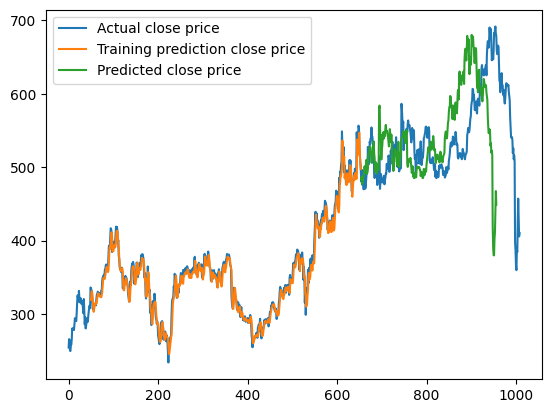

In [56]:
look_back=50
trainPredPlot=np.empty_like(data)
trainPredPlot[:,:]=np.nan
trainPredPlot[look_back:len(train_predict)+look_back,:]=train_predict
testPredPlot=np.empty_like(data)
testPredPlot[:, :]=np.nan
testPredPlot[len(train_predict)+look_back:len(train_predict)+look_back+len(test_predict),:]=test_predict

plt.plot(df,label="Actual close price")
plt.plot(trainPredPlot,label="Training prediction close price")
plt.plot(testPredPlot,label="Predicted close price")
plt.legend()
plt.show()

# **Forecast**

In [59]:
input_data=np.array(df[-time_step:])
input_data=input_data.reshape([input_data.shape[0],1])

In [60]:
def predict(data,days=30):
    data=scaler.transform(data)
    predictions=[]
    i=1
    while(i<=days):
        nxtday=model.predict([data],verbose=0)
        predictions.append(scaler.inverse_transform(nxtday)[0])
        data[:-1]=data[1:]
        data[-1]=nxtday[0]
        i+=1
    return np.array(predictions).squeeze()

In [61]:
days=30
predictions=predict(input_data,days)
# predictions

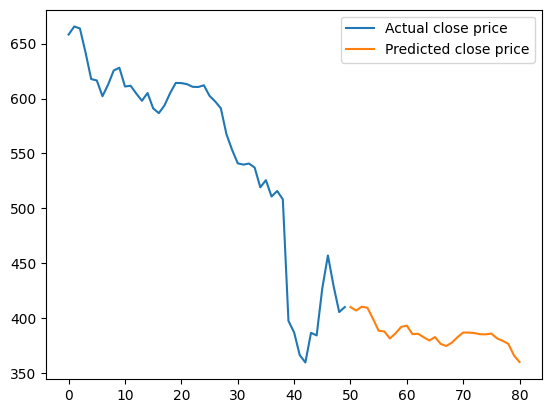

In [62]:
trainPredPlot=np.zeros(shape=[len(input_data)+1+days])
trainPredPlot[:]=np.nan
trainPredPlot[len(input_data)]=input_data[-1]
trainPredPlot[len(input_data)+1:]=predictions
df_=input_data
plt.plot(df_,label="Actual close price")
plt.plot(trainPredPlot,label="Predicted close price")
plt.legend()
plt.show()